### Sales Prediction

**Motivation! What's the context?**
- In 2017 Olist started to forecast its monthly sales based on the average revenue from 3 months before. But now the company  wants to be able to predict future sales more accurately.

**Why?**
- To efficiently allocate resources for future projects, growth and manage its cash flow. 

**Who are the stakeholders?**
- The financial sector will use the forecast to the set operating budgets and to project cash flows.
- And the marketing team, who will have the opportunity to schedule promotions if it appears sales <br>
will be weak and will be able to better allocate budget among other marketing activities.

**What is the deliverable?**
- A dashboard with the information about the forecast.


> **ps: We will use the data to forecast the second quarter of 2018 and the third quarter will be our "production data".**


## Agenda 

[1.0 Describe Data](#1.0-Describe-Data)<br>
&emsp;[1.1 Dealing with Missing Values](#1.1-Dealing-with-Missing-Values)<br>
&emsp;&emsp;[1.1.1 Filling in Missing Values](#1.1.1-Filling-in-Missing-Values)<br>
&emsp;&emsp;[1.1.2 Drop Missing Values](#1.1.2-Drop-Missing-Values)<br>
&emsp;[1.2 Change Data Types](#1.2-Change-Data-Types)<br>
&emsp;&emsp;[Saving Preprocessed "Database"](#Saving-Preprocessed-"Database")

[2.0 Sales Analytical Base Table](#2.0-Sales-Analytical-Base-Table)<br>
&emsp;[2.1 Merging Data](#2.1-Merging-Data)<br>
&emsp;&emsp;[2.1.2 Dropping Duplicates and NaN](#2.1.2-Dropping-Duplicates-and-NaN)<br>
&emsp;&emsp;[2.1.3 Filtering Date Range](#2.1.3-Filtering-Date-Range)<br>
&emsp;[2.2 Descriptive Statistical](#2.2-Descriptive-Statistical)<br>
&emsp;&emsp;[2.2.1 Numerical Attributes](#2.2.1-Numerical-Attributes)<br>
&emsp;&emsp;[2.2.2 Categorical Attributes](#2.2.2-Categorical-Attributes)

[3.0 Hypothesis Creation](#3.0-Hypothesis-Creation)<br>

[4.0 Feature Engineering](#4.0-Feature-Engineering)<br>
&emsp;[4.1 purchase_date_is_holiday](#4.1-purchase_date_is_holiday)<br>
&emsp;[4.2 year_month_day_weekofyear](#4.2-year_month_day_weekofyear)<br>
&emsp;[4.3 freight_percentage_from_price](#4.3-freight_percentage_from_price)<br>
&emsp;[4.4 region](#4.4-region)<br>
&emsp;[4.5 sellers_per_state_region](#4.5-sellers_per_state_region)<br>
&emsp;[4.6 capitals](#4.6-capitals)

[5.0 2018 Exploratory Data Analysis](#5.0-2018-Exploratory-Data-Analysis)<br>
&emsp;[5.1 Univariate Analysis](#5.1-Univariate-Analysis)<br>
&emsp;&emsp;[5.1.1. Response Variable](#5.1.1.-Response-Variable)<br>
&emsp;&emsp;[5.1.2. Numerical Variables](#5.1.2.-Numerical-Variables)<br>
&emsp;&emsp;[5.1.3. Categorical Variables](#5.1.3.-Categorical-Variables)<br>
&emsp;[5.2 Bivariate Analysis](#5.2-Bivariate-Analysis)<br>
&emsp;&emsp;[1 - Weekends and Holidays have higher mean revenue.](#1---Weekends-and-Holidays-have-higher-mean-revenue.)<br>
&emsp;&emsp;[2 - Capitals have higher revenue.](#2---Capitals-have-higher-revenue.)<br>
&emsp;&emsp;[3 - Cities with more customers have higher revenue.](#3---Cities-with-more-customers-have-higher-revenue.)<br>
&emsp;&emsp;[4 - States with more customers have higher mean revenue.](#4---States-with-more-customers-have-higher-mean-revenue.)<br>
&emsp;[5.3 Multivariate Analysis](#5.3-Multivariate-Analysis)<br>
&emsp;&emsp;[5.3.1. Numerical Attributes](#5.3.1.-Numerical-Attributes)<br>
&emsp;&emsp;[5.3.2. Categorical Attributes](#5.3.2.-Categorical-Attributes)<br>

## 0.0 Imports

In [549]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import re
import gc
import holidays

import os
from IPython.display import Image

In [2]:
# Settings
__file__ = "1.0-pr-sales-prediction-eda"
THIS_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'))

### 0.1 Helper Functions

In [550]:
def db_mer_schema():
    return Image( os.path.join(os.path.join(DATA_DIR, 'images'), 'mer.png') )

def describe_data(data):
    print(f"Shape: {data.shape}")
    print(f"Duplicates: {data.duplicated().any()}")
    
    is_na = data.isna().sum()
    is_na_percentage = data.isna().sum()/data.shape[0]*100
    nan_data_frame = pd.concat([data.dtypes, is_na, is_na_percentage], axis=1)
    nan_data_frame.columns = ['data_types', 'nan_count', 'nan_percentage']
    return nan_data_frame

# 1.2 Dealing with Missing Values
def missing_plot(data, nan_cols, no_nan_col, x=15, y=5, first_graph=True, second_graph=True):
    nan_cols.insert(0, no_nan_col)
    try:
        if first_graph:
            msno.matrix(data[nan_cols], figsize=(x, y))
            plt.show()
        if second_graph:
            msno.bar(data[nan_cols], figsize=(x, y))
            plt.show()
    except Exception as e:
        print(e)
        
        
def map_regions(state):
    regions = {
        'north': ['AM','RR','AP','PA','TO','RO','AC'],
        'northeast': ['MA','PI','CE','RN','PE','PB','SE','AL','BA'],
        'midwest': ['MT','MS','GO','DF'],
        'southeast': ['SP','RJ','ES','MG'],
        'south': ['PR','RS','SC']
    }
    for region, states in regions.items():
        if state in states:
            return region

### 0.2 Loading Data

In [4]:
olist_datasets = os.listdir(os.path.join(DATA_DIR, 'raw_data'))
datasets = {}
for dataset in olist_datasets:
    dataset_name = re.sub('olist_|_dataset|.csv', '', dataset)
    datasets[dataset_name] = pd.read_csv(os.path.join(os.path.join(DATA_DIR, 'raw_data'), dataset))
    
    print(f"Loading {dataset_name}...")
print("Process Finished!")

Loading customers...
Loading geolocation...
Loading orders...
Loading order_items...
Loading order_payments...
Loading order_reviews...
Loading products...
Loading sellers...
Loading product_category_name_translation...
Process Finished!


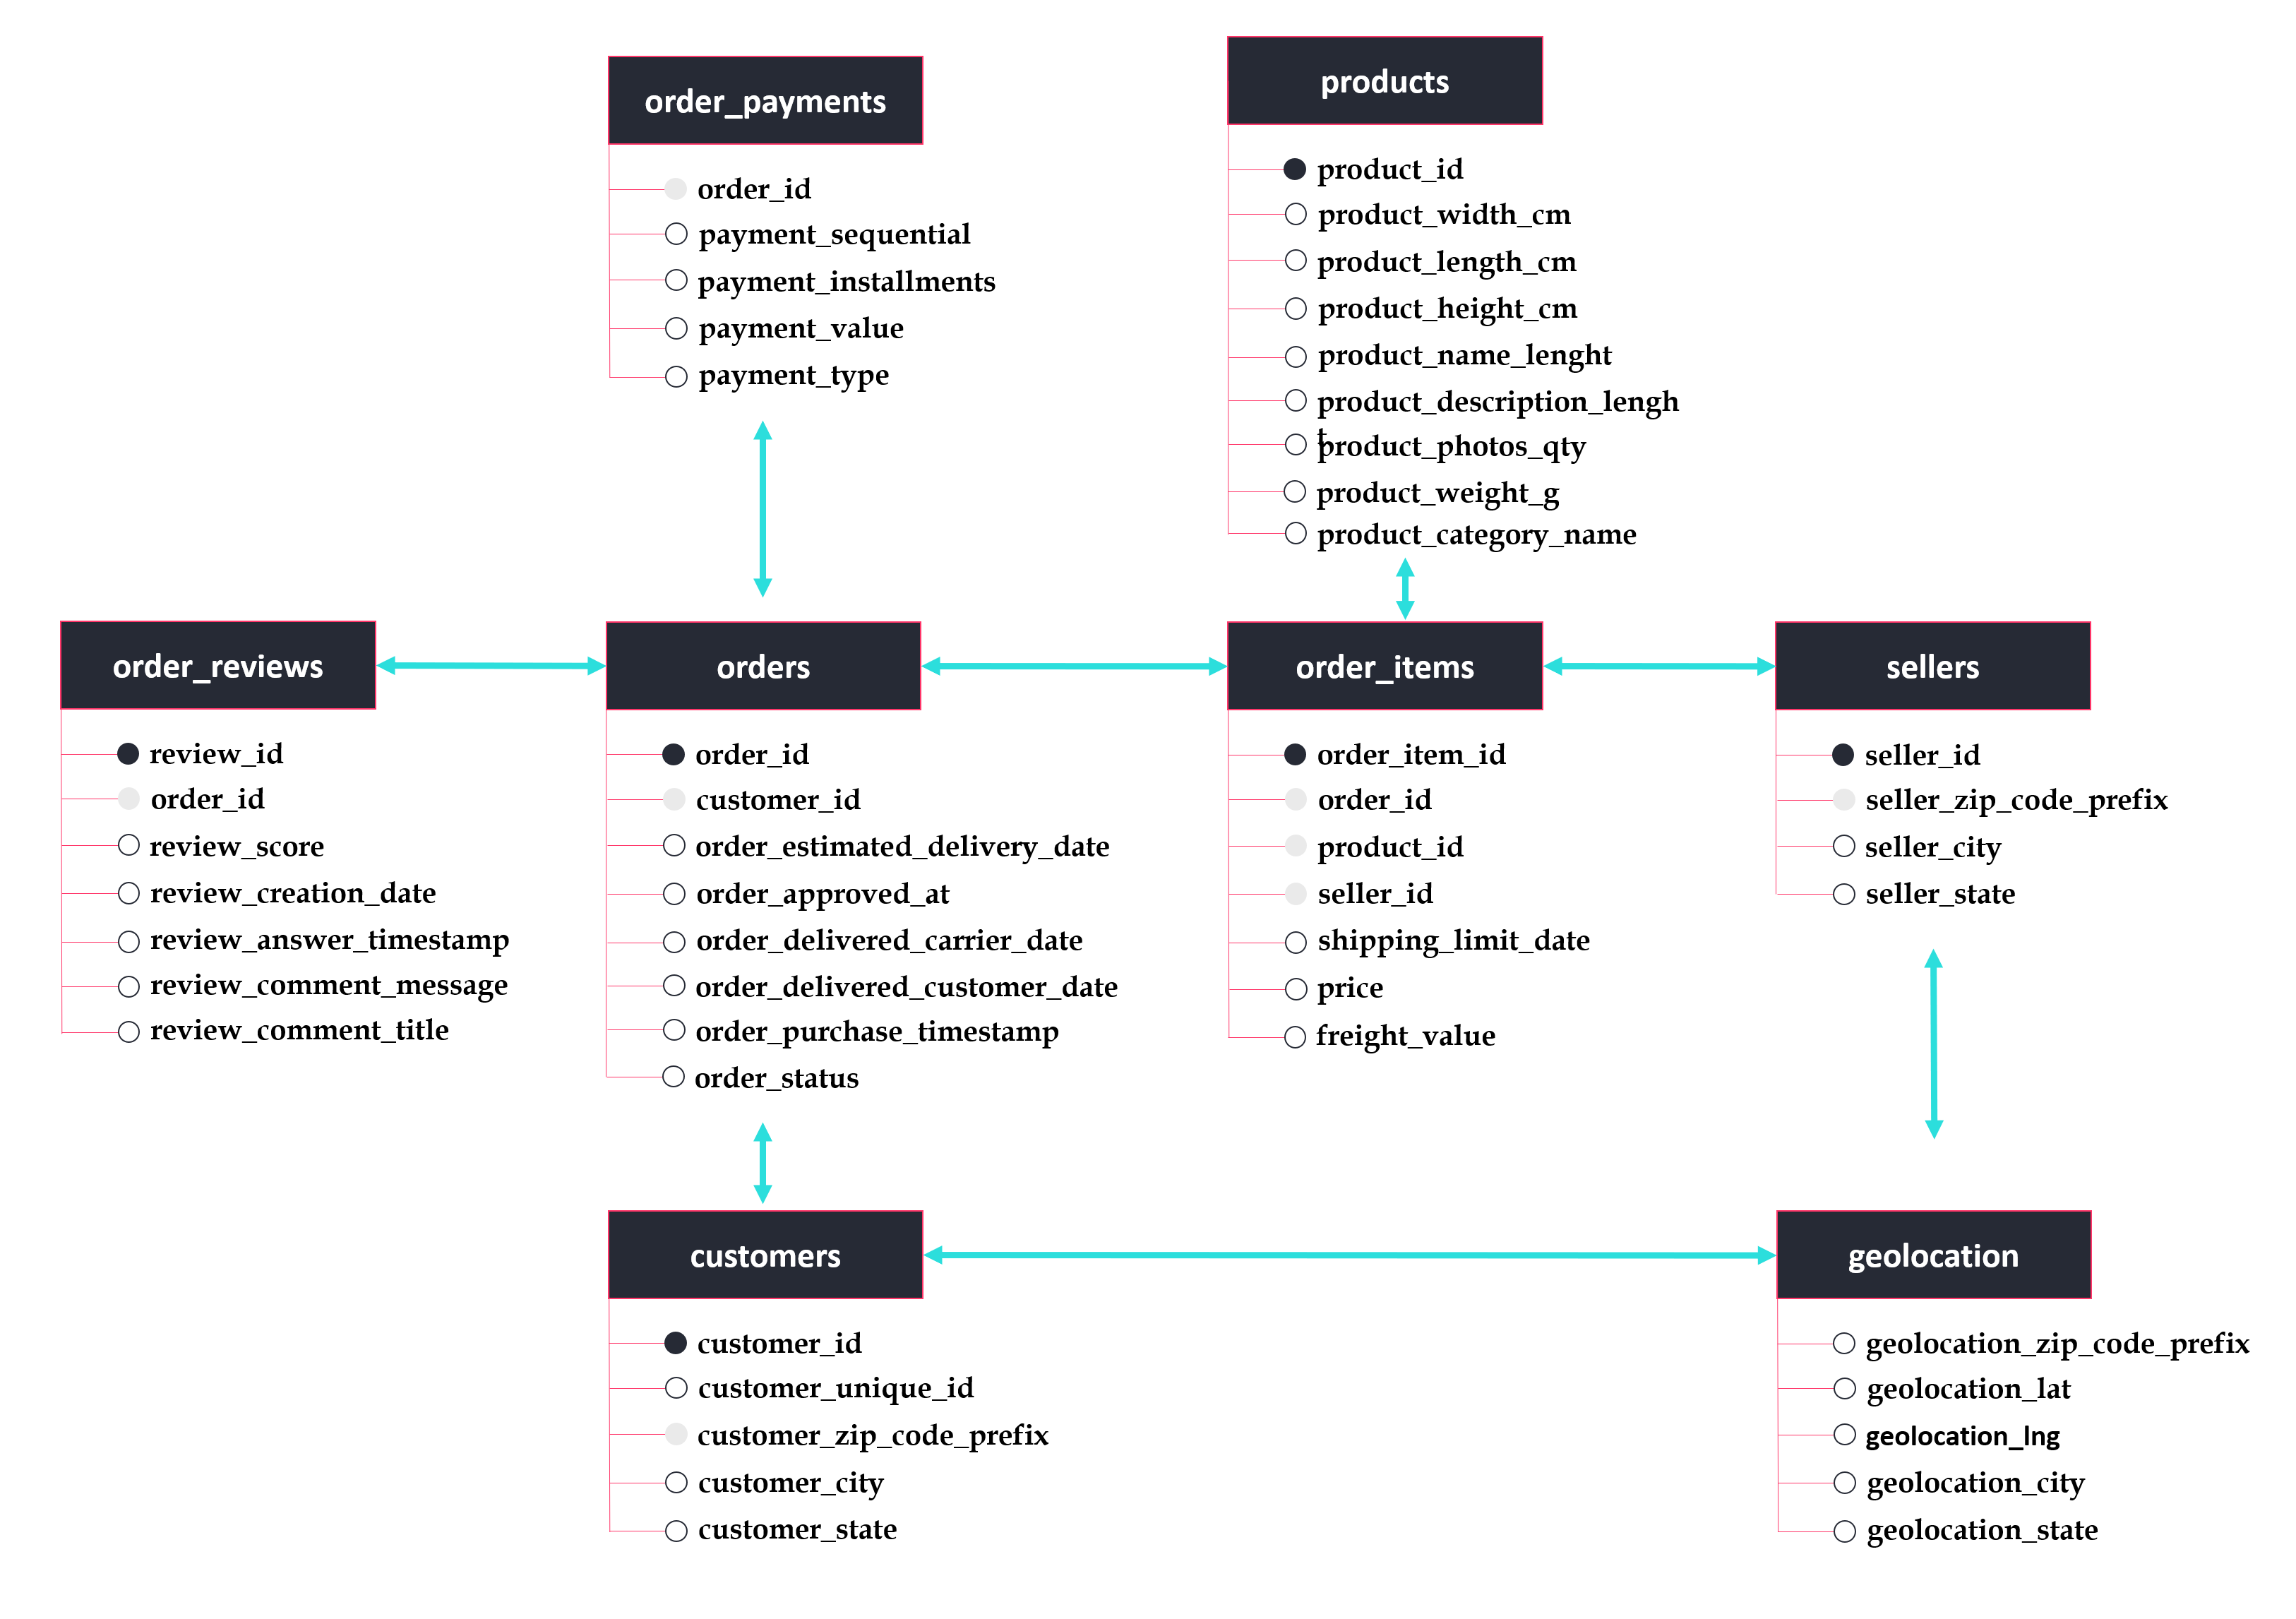

In [5]:
db_mer_schema()

## 1.0 Describe Data

        ORDERS
            Change to Datetime data type:
                order_purchase_timestamp	
                order_approved_at	          drop NaN? 0.16%
                order_delivered_carrier_date   drop NaN? 1.79%
                order_delivered_customer_date  drop NaN? 2.98%
                order_estimated_delivery_date
            
        ORDER_ITEMS
            Change to Datetime data type:
                shipping_limit_date
            
        ORDER_REVIEWS
            Change to Datetime data type:
                review_creation_date	
                review_answer_timestamp	
            Drop NaN?
                review_comment_title    88.28%
                review_comment_message  58.24%   
                
        PRODUCTS
            Drop NaN?
                product_category_name        1.851%
                product_name_lenght          1.851%
                product_description_lenght   1.851%
                product_photos_qty           1.851%
                product_weight_g             0.006%
                product_length_cm            0.006%
                product_height_cm            0.006%
                product_width_cm             0.006%

In [6]:
for dataset in datasets.keys():
    print("\t\t\t",dataset.upper())
    display(describe_data(datasets[dataset])), print("\n\n")

			 CUSTOMERS
Shape: (99441, 5)
Duplicates: False


,data_types,nan_count,nan_percentage
customer_id,object,0,0.0
customer_unique_id,object,0,0.0
customer_zip_code_prefix,int64,0,0.0
customer_city,object,0,0.0
customer_state,object,0,0.0





			 GEOLOCATION
Shape: (1000163, 5)
Duplicates: True


,data_types,nan_count,nan_percentage
geolocation_zip_code_prefix,int64,0,0.0
geolocation_lat,float64,0,0.0
geolocation_lng,float64,0,0.0
geolocation_city,object,0,0.0
geolocation_state,object,0,0.0





			 ORDERS
Shape: (99441, 8)
Duplicates: False


,data_types,nan_count,nan_percentage
order_id,object,0,0.000000
customer_id,object,0,0.000000
order_status,object,0,0.000000
order_purchase_timestamp,object,0,0.000000
order_approved_at,object,160,0.160899
order_delivered_carrier_date,object,1783,1.793023
order_delivered_customer_date,object,2965,2.981668
order_estimated_delivery_date,object,0,0.000000





			 ORDER_ITEMS
Shape: (112650, 7)
Duplicates: False


,data_types,nan_count,nan_percentage
order_id,object,0,0.0
order_item_id,int64,0,0.0
product_id,object,0,0.0
seller_id,object,0,0.0
shipping_limit_date,object,0,0.0
price,float64,0,0.0
freight_value,float64,0,0.0





			 ORDER_PAYMENTS
Shape: (103886, 5)
Duplicates: False


,data_types,nan_count,nan_percentage
order_id,object,0,0.0
payment_sequential,int64,0,0.0
payment_type,object,0,0.0
payment_installments,int64,0,0.0
payment_value,float64,0,0.0





			 ORDER_REVIEWS
Shape: (100000, 7)
Duplicates: False


,data_types,nan_count,nan_percentage
review_id,object,0,0.000
order_id,object,0,0.000
review_score,int64,0,0.000
review_comment_title,object,88285,88.285
review_comment_message,object,58247,58.247
review_creation_date,object,0,0.000
review_answer_timestamp,object,0,0.000





			 PRODUCTS
Shape: (32951, 9)
Duplicates: False


,data_types,nan_count,nan_percentage
product_id,object,0,0.000000
product_category_name,object,610,1.851234
product_name_lenght,float64,610,1.851234
product_description_lenght,float64,610,1.851234
product_photos_qty,float64,610,1.851234
product_weight_g,float64,2,0.006070
product_length_cm,float64,2,0.006070
product_height_cm,float64,2,0.006070
product_width_cm,float64,2,0.006070





			 SELLERS
Shape: (3095, 4)
Duplicates: False


,data_types,nan_count,nan_percentage
seller_id,object,0,0.0
seller_zip_code_prefix,int64,0,0.0
seller_city,object,0,0.0
seller_state,object,0,0.0





			 PRODUCT_CATEGORY_NAME_TRANSLATION
Shape: (71, 2)
Duplicates: False


,data_types,nan_count,nan_percentage
product_category_name,object,0,0.0
product_category_name_english,object,0,0.0


### 1.1 Dealing with Missing Values

1. Analyze. 
2. Decide What to Do.
3. Do it.

**Orders**

        Drop: (few data and they may not interfere in our EDA)
            order_approved_at	          
            order_delivered_carrier_date   
            order_delivered_customer_date  

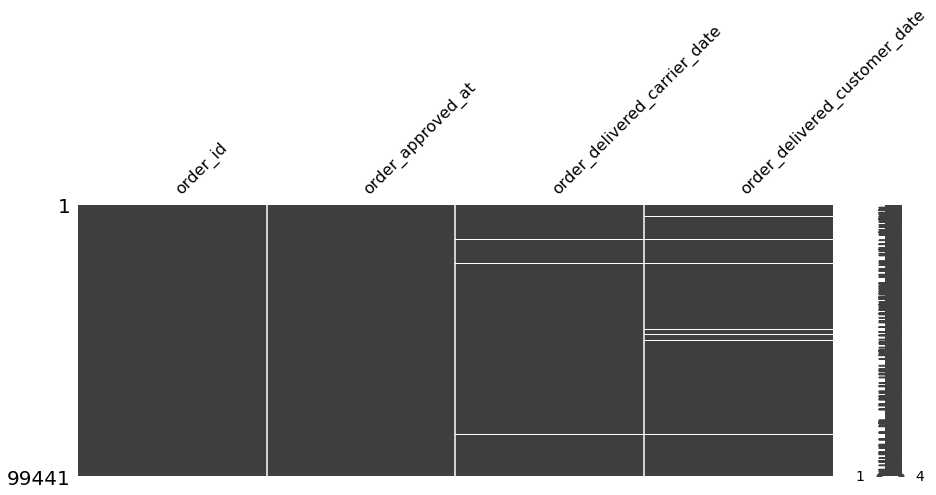

In [6]:
nan_cols = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']
missing_plot(datasets['orders'], nan_cols, 'order_id', second_graph=False)

**Order Reviews**

        Fill in: (with None or NO REVIEW)
            review_comment_title    
            review_comment_message  

In [7]:
datasets['order_reviews'].head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


**Products**

        Fill in:
            product_category_name         "other"
            product_name_lenght           median (skewed data)
            product_description_lenght    median
            product_photos_qty            1      (products have at least 1 photo)
        
        Drop:(2 observations only)
            product_weight_g   
            product_length_cm
            product_height_cm
            product_width_cm 

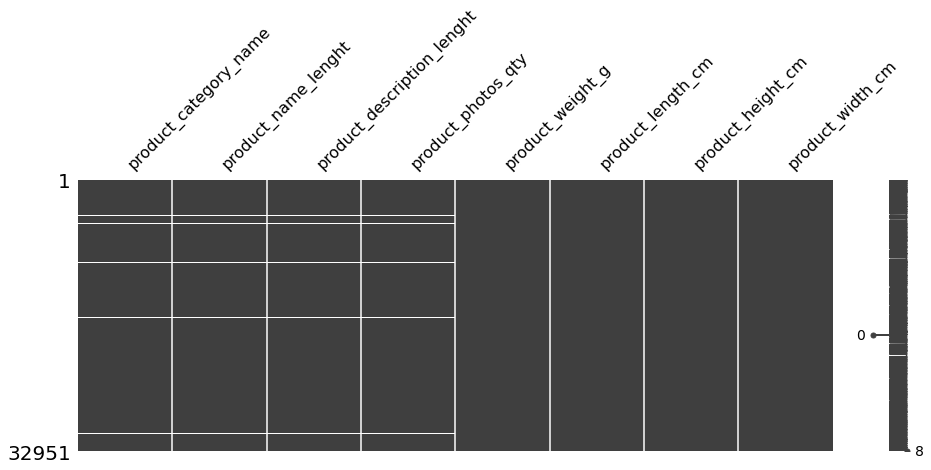

In [8]:
nan_cols = datasets['products'].columns.drop('product_id')
missing_plot(datasets['products'], nan_cols, 'product_id', second_graph=False)

In [9]:
# datasets['products']['product_name_lenght'].hist()
# datasets['products']['product_description_lenght'].hist()

In [10]:
datasets['products'].min()

product_id                    00066f42aeeb9f3007548bb9d3f33c38
product_name_lenght                                          5
product_description_lenght                                   4
product_photos_qty                                           1
product_weight_g                                             0
product_length_cm                                            7
product_height_cm                                            2
product_width_cm                                             6
dtype: object

### 1.1.1 Filling in Missing Values

Let's fill first and drop later.


        Order Reviews (with None or NO REVIEW)
            review_comment_title    
            review_comment_message
            
        Products
            product_category_name         "OTHER"
            product_name_lenght           median (skewed data)
            product_description_lenght    median
            product_photos_qty            1      (products have at least 1 photo)

In [6]:
datasets['order_reviews']['review_comment_title'].fillna("_NO_TITLE", inplace=True)
datasets['order_reviews']['review_comment_message'].fillna("_NO_MESSAGE", inplace=True)

In [7]:
datasets['products']['product_category_name'].fillna("OTHER", inplace=True)
datasets['products']['product_name_lenght'].fillna(datasets['products']['product_name_lenght'].median(), inplace=True)
datasets['products']['product_description_lenght'].fillna(datasets['products']['product_description_lenght'].median(), inplace=True)
datasets['products']['product_photos_qty'].fillna(1, inplace=True)

### 1.1.2 Drop Missing Values

In [8]:
datasets['orders'].dropna(inplace=True)
datasets['products'].dropna(inplace=True)

## 1.2 Change Data Types

        Change to Datetime data type:
        
            ORDERS
                order_purchase_timestamp    
                order_approved_at              
                order_delivered_carrier_date   
                order_delivered_customer_date
                order_estimated_delivery_date

            ORDER_ITEMS
                shipping_limit_date

            ORDER_REVIEWS
                review_creation_date    
                review_answer_timestamp    


In [9]:
columns_to_datetime = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                       'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in columns_to_datetime:
    datasets['orders'][col] = pd.to_datetime(datasets['orders'][col])

In [10]:
datasets['order_items']['shipping_limit_date'] = pd.to_datetime(datasets['order_items']['shipping_limit_date'])

In [11]:
columns_to_datetime = ['review_creation_date', 'review_answer_timestamp']
for col in columns_to_datetime:
    datasets['order_reviews'][col] = pd.to_datetime(datasets['order_reviews'][col])

#### Saving Preprocessed "Database"

In [17]:
for col in datasets.keys():
    print(f"Saving {col} to pickle")
    datasets[col].to_pickle(os.path.join(os.path.join(DATA_DIR, 'preprocessed_database'), f'{col}.pkl'))

Saving customers to pickle
Saving geolocation to pickle
Saving orders to pickle
Saving order_items to pickle
Saving order_payments to pickle
Saving order_reviews to pickle
Saving products to pickle
Saving sellers to pickle
Saving product_category_name_translation to pickle


## 2.0 Sales Analytical Base Table

### 2.1 Merging Data

In [12]:
def _abt_desc(analytical_base_table):
    print(f'''Shape: {analytical_base_table.shape} | Duplicates: {analytical_base_table.duplicated().any()} | NaN: {analytical_base_table.isna().sum().sum()}''')

In [13]:
datasets['orders'].shape

(96461, 8)

In [14]:
sales_abt = datasets['orders'].merge(datasets['customers'], how='left', on='customer_id')
_abt_desc(sales_abt)
sales_abt = sales_abt.merge(datasets['order_items'], how='left', on='order_id')
_abt_desc(sales_abt)
sales_abt = sales_abt.merge(datasets['geolocation'].drop_duplicates(subset='geolocation_zip_code_prefix'),
                            how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
_abt_desc(sales_abt)

Shape: (96461, 12) | Duplicates: False | NaN: 0
Shape: (110180, 18) | Duplicates: False | NaN: 0
Shape: (110180, 23) | Duplicates: False | NaN: 1440


In [15]:
del datasets
gc.collect()

20

### 2.1.2 Dropping Duplicates and NaN

In [16]:
sales_abt.drop_duplicates(inplace=True)
sales_abt.dropna(inplace=True)
describe_data(sales_abt)

Shape: (109892, 23)
Duplicates: False


,data_types,nan_count,nan_percentage
order_id,object,0,0.0
customer_id,object,0,0.0
order_status,object,0,0.0
order_purchase_timestamp,datetime64[ns],0,0.0
order_approved_at,datetime64[ns],0,0.0
order_delivered_carrier_date,datetime64[ns],0,0.0
order_delivered_customer_date,datetime64[ns],0,0.0
order_estimated_delivery_date,datetime64[ns],0,0.0
customer_unique_id,object,0,0.0
customer_zip_code_prefix,int64,0,0.0


### 2.1.3 Filtering Date Range

**We'll use data starting from 2017 to predict the second quarter of 2018 up to the third one.**

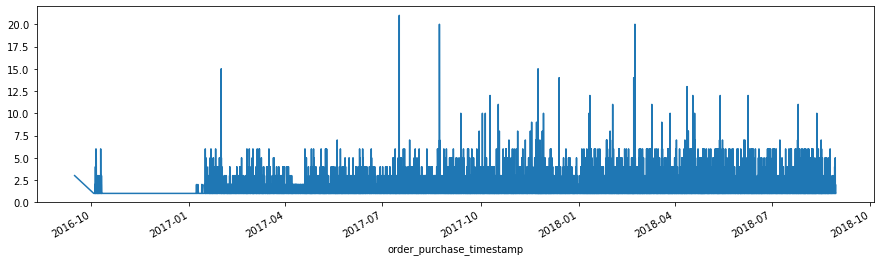

In [23]:
sales_abt.groupby("order_purchase_timestamp").order_id.count().plot(figsize=(15,4));

In [24]:
sales_abt.shape

(109892, 23)

In [17]:
mask = (sales_abt['order_purchase_timestamp'] >= '2017-1-1') & (sales_abt['order_purchase_timestamp'] < '2018-10-1')
sales_abt = sales_abt.loc[mask]
sales_abt.shape

(109569, 23)

In [18]:
109892-109569 # only 323 records from 2016

323

### 2.2 Descriptive Statistical


##### 2.2.1 Numerical Attributes

    customer_zip_code_prefix and geolocation_zip_code_prefix are the same. (Drop one of them later)
    
    freight_value and price are highly skewed, so We have a lot of "low value" purchases.
    
    order_item_id: Each order usually have 1 item.

In [27]:
numerical_attributes = sales_abt.select_dtypes( include=['int64', 'float64'] )
categorical_attributes = sales_abt.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [28]:
skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew()), columns=['skew']).T
kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis()), columns=['kurtosis']).T

cols = ['customer_zip_code_prefix','geolocation_zip_code_prefix', 'freight_value', 'price',
       'order_item_id', 'geolocation_lat', 'geolocation_lng']
stats = pd.concat([sales_abt.describe()[cols], skew, kurtosis]).round(2).T

def style_specific_cell(x):
    df = pd.DataFrame('', index=x.index, columns=x.columns)    
    df.iloc[2:5, 0] = 'background-color: lightgrey'
    df.iloc[2:5, 4] = 'background-color: lightblue'     
    return df

stats.drop(columns='count').style.apply(style_specific_cell, axis=None).format("{:.2f}")

,mean,std,min,25%,50%,75%,max,skew,kurtosis
customer_zip_code_prefix,35067.52,29884.87,1003.00,11088.00,24241.00,58701.00,99980.00,0.79,-0.78
geolocation_zip_code_prefix,35067.52,29884.87,1003.00,11088.00,24241.00,58701.00,99980.00,0.79,-0.78
freight_value,19.94,15.71,0.00,13.07,16.25,21.15,409.68,5.66,60.69
price,119.94,182.39,0.85,39.90,74.90,134.00,6735.00,8.05,125.37
order_item_id,1.20,0.71,1.00,1.00,1.00,1.00,21.00,7.64,105.19
geolocation_lat,-21.25,5.57,-36.61,-23.59,-22.93,-20.20,42.18,1.68,3.68
geolocation_lng,-46.22,4.04,-72.67,-48.13,-46.63,-43.67,-8.58,0.03,2.39


##### 2.2.2 Categorical Attributes

    price
        prices distributions among states are similar at some level.
        
    freight_value
        Freight is quite different among some states (just like we analyzed in the previous Business Insights Project).
        
[Business Insights Project](https://github.com/pauloreis-ds/olist/tree/main/business_questions_insights)

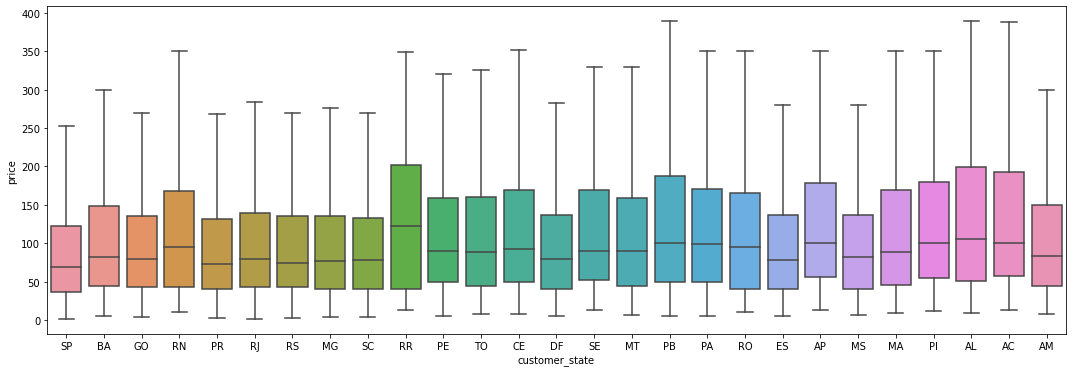

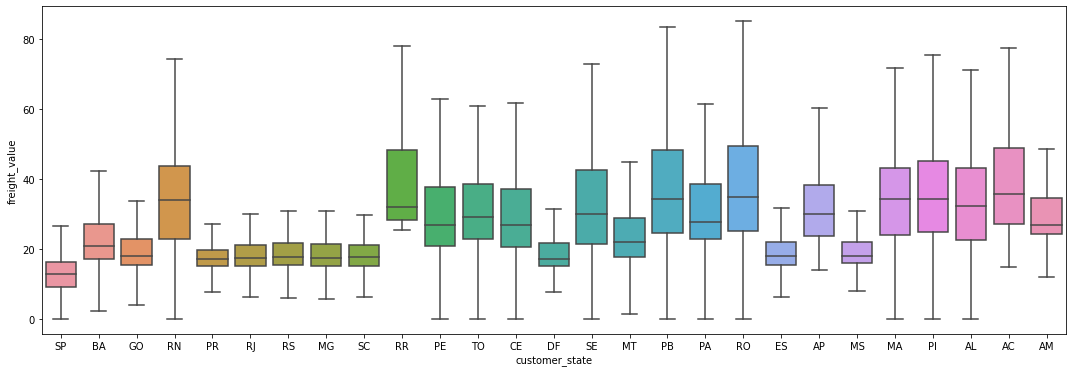

In [29]:
numerical_attr = ['price', 'freight_value']
categorical_attr = ['customer_state']

rows = len(numerical_attr); columns = len(categorical_attr); plot = 0

for n_attribute in numerical_attr:
    plt.figure(figsize=(15,10))
    plot += 1
    plt.subplot( rows, columns, plot )
    sns.boxplot( x='customer_state', y = n_attribute, data=sales_abt, showfliers=False)    
    plt.tight_layout()

In [30]:
categorical_attributes.order_status.value_counts()

delivered    109568
canceled          1
Name: order_status, dtype: int64

## 3.0 Hypothesis Creation

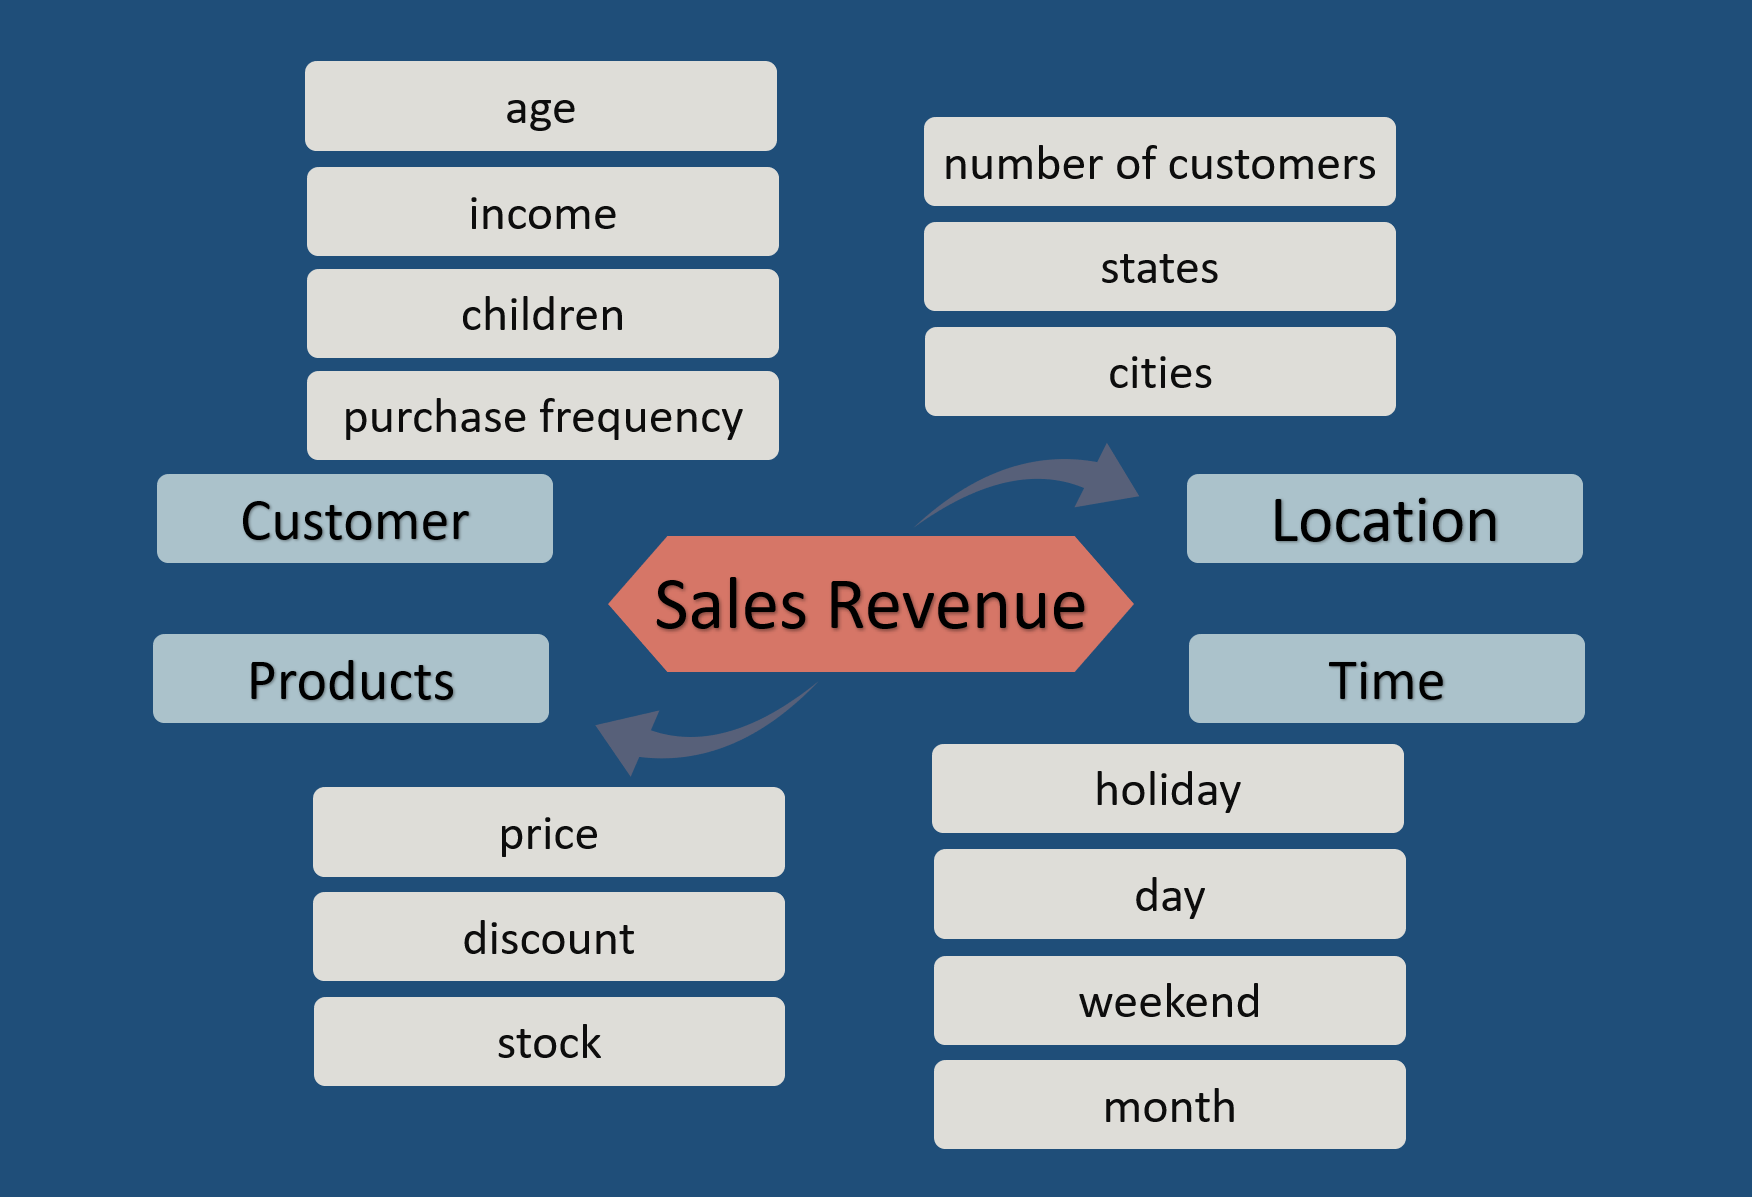

In [60]:
Image("../images/hypothesis_mind_map.png", width=650)

**1 - Weekends and Holidays have higher mean revenue.**

**2 - Capitals have higher revenue.**

**3 - Cities with more customers have higher revenue.**

**4 - States with more customers have higher mean revenue.**

## 4.0 Feature Engineering

In [140]:
df = sales_abt.copy()

#### 4.1 purchase_date_is_holiday

In [122]:
brazilian_holidays = holidays.Brazil()

In [141]:
df['purchase_timestamp_is_holyday'] = df['order_purchase_timestamp'].apply(lambda date: True if date in brazilian_holidays else False)
df['estimated_delivery_date_is_holyday'] = df['order_estimated_delivery_date'].apply(lambda date: True if date in brazilian_holidays else False)

#### 4.2 year_month_day_weekofyear

In [142]:
df['purchase_timestamp_year'] = df['order_purchase_timestamp'].dt.year
df['estimated_delivery_date_year'] = df['order_estimated_delivery_date'].dt.year

df['purchase_timestamp_month'] = df['order_purchase_timestamp'].dt.month
df['estimated_delivery_date_month'] = df['order_estimated_delivery_date'].dt.month

df['purchase_timestamp_day'] = df['order_purchase_timestamp'].dt.day
df['estimated_delivery_date_day'] = df['order_estimated_delivery_date'].dt.day

df['purchase_timestamp_weekofyear'] = df['order_purchase_timestamp'].dt.isocalendar().week
df['estimated_delivery_date_weekofyear'] = df['order_estimated_delivery_date'].dt.isocalendar().week

df['purchase_timestamp_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek
df['estimated_delivery_date_dayofweek'] = df['order_estimated_delivery_date'].dt.dayofweek

#### 4.3 freight_percentage_from_price

In [147]:
df['freight_percentage_from_price'] = df['freight_value'] / df['price']

#### 4.4 region

In [156]:
df['region'] = df['customer_state'].apply(map_regions)

#### 4.5 sellers_per_state_region

In [159]:
# df.groupby("customer_state")['seller_id'].nunique().to_dict()

In [171]:
def _map_sellers_quantity(state):
    states = {'AC': 71, 'AL': 245, 'AM': 116, 'AP': 62, 'BA': 946, 'CE': 506, 'DF': 738, 'ES': 724, 'GO': 708,
               'MA': 363, 'MG': 1625, 'MS': 401, 'MT': 456, 'PA': 454, 'PB': 295, 'PE': 619, 'PI': 289, 'PR': 1201,
               'RJ': 1695, 'RN': 269, 'RO': 180, 'RR': 34, 'RS': 1199, 'SC': 1013, 'SE': 206, 'SP': 2429, 'TO': 193}
    for states_list, sellers_quantity in states.items():
        if state in states_list:
            return sellers_quantity

In [173]:
df['sellers_in_state'] = df['customer_state'].apply(_map_sellers_quantity)

In [160]:
# df.groupby("region")['seller_id'].nunique().to_dict()

In [174]:
def _map_sellers_quantity(region):
    regions = { 'midwest': 1223,
                'north': 696,
                'northeast': 1427,
                'south': 1780,
                'southeast': 2721}
    for regions_list, sellers_quantity in regions.items():
        if region in regions_list:
            return sellers_quantity

In [176]:
df['sellers_in_region'] = df['region'].apply(_map_sellers_quantity)

#### 4.6 capitals

In [ ]:
capitals = pd.read_csv(os.path.join(os.path.join(DATA_DIR, "sales_forecast_data"), "brazil_capitals.csv"))['Sede de governo']
capitals = capitals.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
capitals = capitals.apply(lambda capital: capital.lower())

In [ ]:
df['city_is_capital'] = df['customer_city'].apply(lambda city: True if city in capitals.tolist() else False)

**Saving to machine learning process.**

In [273]:
df.to_pickle(os.path.join(os.path.join(DATA_DIR, "sales_forecast_data"), "ml_data_to_preprocess.pkl"))

## 5.0 2018 Exploratory Data Analysis

In [306]:
mask = (df['order_purchase_timestamp'] >= '2018-1-1')
df = df.loc[mask]

In [525]:
numerical_attributes = df.select_dtypes( include=['int64', 'float64'] )
categorical_attributes = df.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]', 'bool'] )

### 5.1 Univariate Analysis

#### 5.1.1. Response Variable

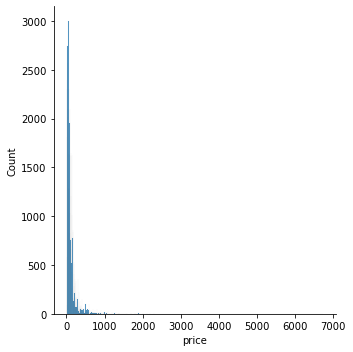

In [401]:
sns.displot(df['price'])

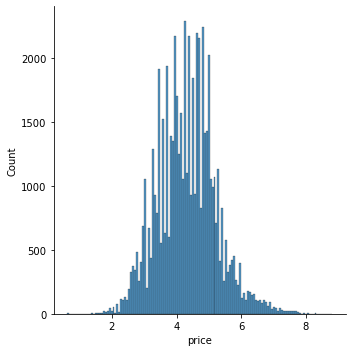

In [403]:
# Normalization 
sns.displot( np.log1p(df['price']) )

#### 5.1.2. Numerical Variables


    We have freight_values greater than 300 but we also have prices higher than 4000, but
    freight_percentage_from_price shows us a freight_value 2000% greater than the order price.
    
    purchase_timestamp_month shows us the sales are decreasing in the 3rd quarter (perhaps 
    because we have less data over time in this period ahead).
    
    purchase_timestamp_day: orders and revenue seem to go down throughout the month and our most
    profitable days appear to be the the first half of the month.

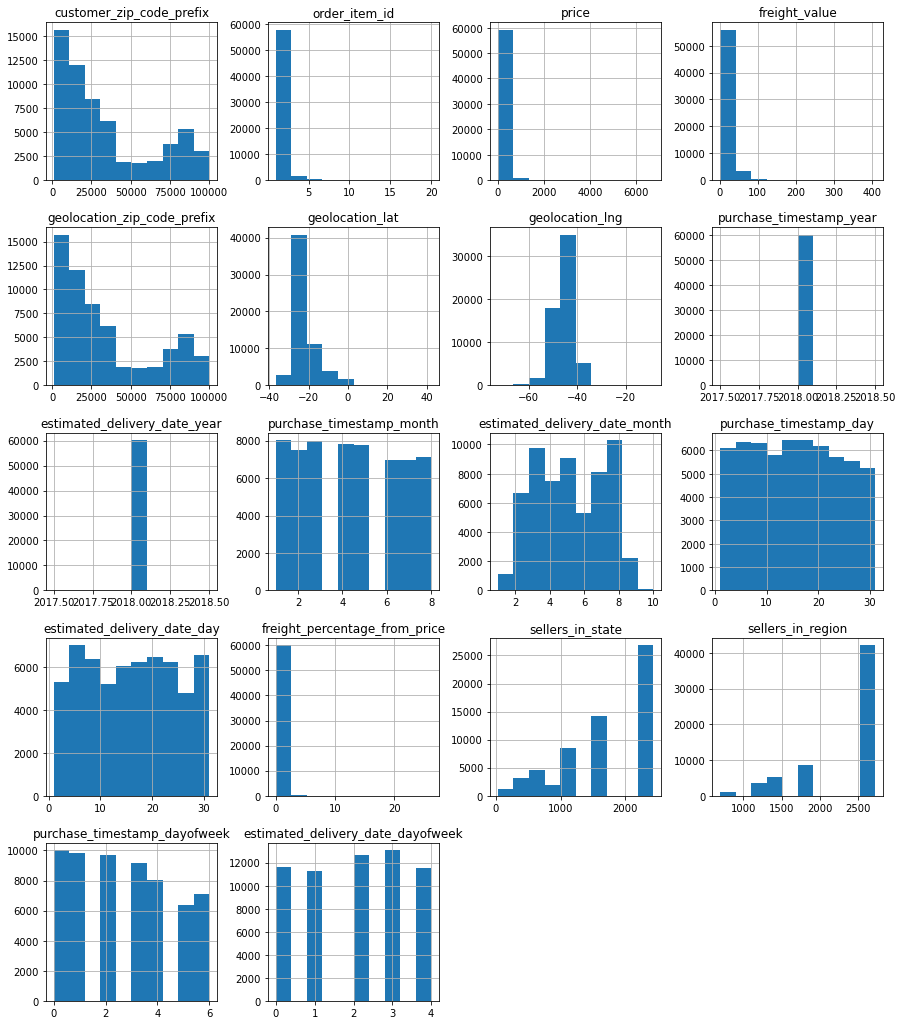

In [433]:
numerical_attributes.hist(figsize=(15,18));

**freight_percentage_from_price**

In [448]:
df[df['freight_percentage_from_price'] > 10][['price', 'freight_value']]

,price,freight_value
58245,0.85,22.30
78699,0.85,18.23
92144,0.85,18.23


In [451]:
df[df['freight_percentage_from_price'] > 1][['price', 'freight_value']].head()

,price,freight_value
27,39.5,48.64
30,30.1,33.24
109,10.9,12.79
133,12.5,14.10
134,12.5,14.10


In [452]:
len(df[df['freight_percentage_from_price'] > 1][['price', 'freight_value']])

2248

**purchase_timestamp_day**

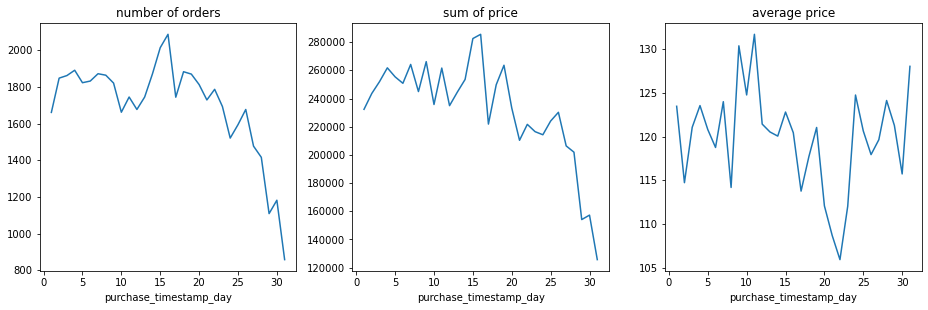

In [486]:
plt.subplot(2, 3, 1)
df.groupby("purchase_timestamp_day")['order_id'].nunique().plot(title='number of orders',figsize=(13,8))
plt.subplot(2, 3, 2)
df.groupby("purchase_timestamp_day")['price'].sum().plot(title='sum of price')
plt.subplot(2, 3, 3)
df.groupby("purchase_timestamp_day")['price'].mean().plot(title='average price')
plt.tight_layout()

**purchase_timestamp_dayofweek**

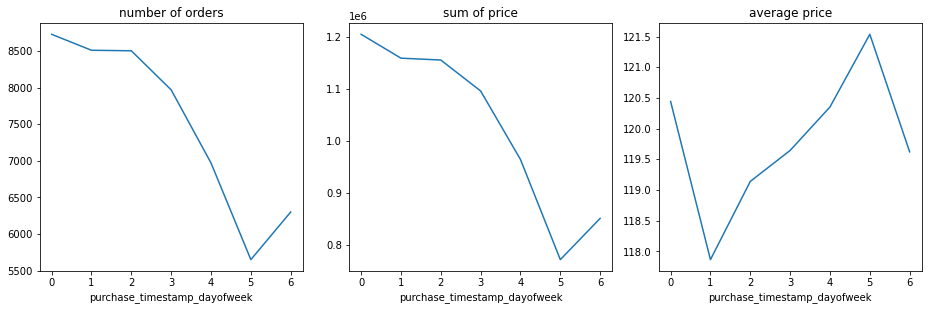

In [487]:
plt.subplot(2, 3, 1)
df.groupby("purchase_timestamp_dayofweek")['order_id'].nunique().plot(title='number of orders',figsize=(13,8))
plt.subplot(2, 3, 2)
df.groupby("purchase_timestamp_dayofweek")['price'].sum().plot(title='sum of price')
plt.subplot(2, 3, 3)
df.groupby("purchase_timestamp_dayofweek")['price'].mean().plot(title='average price')
plt.tight_layout()

**purchase_timestamp_weekofyear**

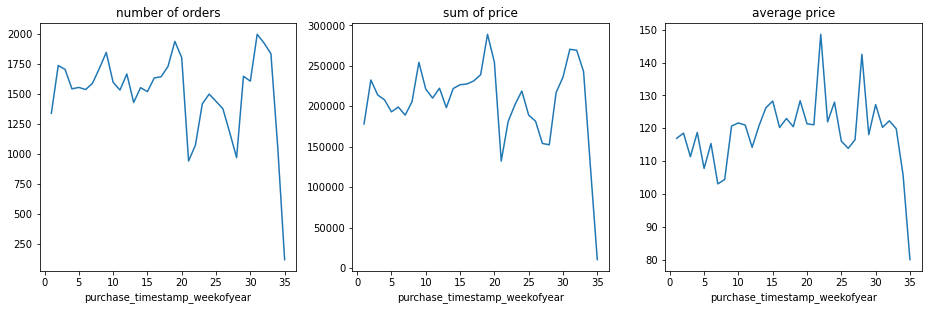

In [488]:
plt.subplot(2, 3, 1)
df.groupby("purchase_timestamp_weekofyear")['order_id'].nunique().plot(title='number of orders',figsize=(13,8))
plt.subplot(2, 3, 2)
df.groupby("purchase_timestamp_weekofyear")['price'].sum().plot(title='sum of price')
plt.subplot(2, 3, 3)
df.groupby("purchase_timestamp_weekofyear")['price'].mean().plot(title='average price')
plt.tight_layout()

#### 5.1.3. Categorical Variables

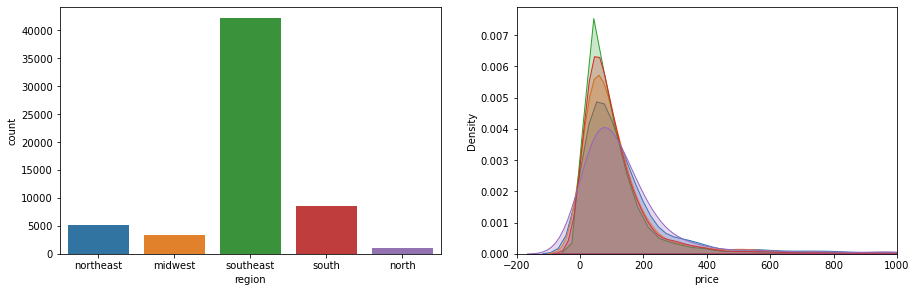

In [522]:
plt.figure(figsize=(15,10))
plt.subplot( 2, 2, 1 )
sns.countplot(x=df['region'])

plt.subplot( 2, 2, 2 )
sns.kdeplot(df[df['region'] == 'northeast']['price'], label='label_1', shade=True)
sns.kdeplot(df[df['region'] == 'midwest']['price'], label='label_2', shade=True)
sns.kdeplot(df[df['region'] == 'southeast']['price'], label='label_3', shade=True)
sns.kdeplot(df[df['region'] == 'south']['price'], label='label_3', shade=True)
sns.kdeplot(df[df['region'] == 'north']['price'], label='label_3', shade=True)
plt.xlim(-200, 1000)

plt.show()

### 5.2 Bivariate Analysis

#### 1 - Weekends and Holidays have higher mean revenue.

Yes, weekends mean revenue is slightly higher than a normal day, but holidays have the lowest mean revenue

In [307]:
# Weekends
df[df['purchase_timestamp_dayofweek'] >= 5]['price'].mean()

120.5255005941671

In [308]:
# Holidays
df[df['purchase_timestamp_is_holyday'] == True]['price'].mean()

115.57177884615233

In [309]:
# Normal Days
df[(df['purchase_timestamp_dayofweek'] < 5) & (df['purchase_timestamp_is_holyday'] == False)]['price'].mean()

119.61202752095105

#### 2 - Capitals have higher revenue.

Yes, 7 capitals are in top 10 cities with higher total revenue.

However, the mean revenues of capital cities are low. 

In [311]:
df.groupby("customer_city")[['price','city_is_capital']].sum().sort_values('price', ascending=False).head(10)

,price,city_is_capital
customer_city,,
sao paulo,1103316.77,10278
rio de janeiro,473740.37,3863
belo horizonte,199179.91,1731
brasilia,153747.32,1227
curitiba,122566.77,985
campinas,103429.74,0
porto alegre,92622.16,787
salvador,91866.76,727
guarulhos,81373.70,0


In [310]:
pd.DataFrame( df.groupby("city_is_capital")['price'].agg(['mean', 'min','median', 'max']) )

,mean,min,median,max
city_is_capital,,,,
False,120.062020,0.85,77.99,4099.99
True,119.114376,3.00,74.80,6729.00


In [340]:
# Mean revenue
df.groupby("customer_city")[['price','city_is_capital']].mean().sort_values('price', ascending=False).head(20)

,price,city_is_capital
customer_city,,
nova esperanca do piria,2199.000000,False
sape,1850.000000,False
mariental,1799.000000,False
bom jesus do galho,1483.963333,False
conceicao das alagoas,1395.000000,False
bom retiro do sul,1250.000000,False
pacaja,1200.000000,False
coari,1190.650000,False
nova roma do sul,1106.990000,False


#### 3 - Cities with more customers have higher revenue.

This is true for cities with really large quantity of customers, but when the gap narrows, it doesn't happen as expected.

In [355]:
aux_df = df.groupby("customer_city")[['customer_id','price']].agg({'customer_id':'nunique','price':'sum'}).sort_values("price", ascending=False)

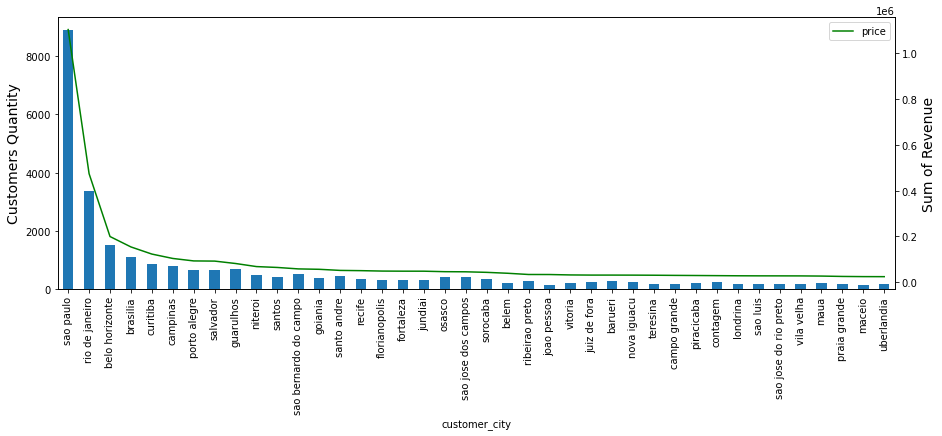

In [380]:
ax = aux_df['customer_id'].head(40).plot(kind='bar', figsize=(15,5))
plt.ylabel("Customers Quantity", size=14)
aux_df['price'].head(40).plot(kind='line', figsize=(15,5), ax = ax.twinx(), color='green')
plt.ylabel("Sum of Revenue", size=14)
plt.legend();

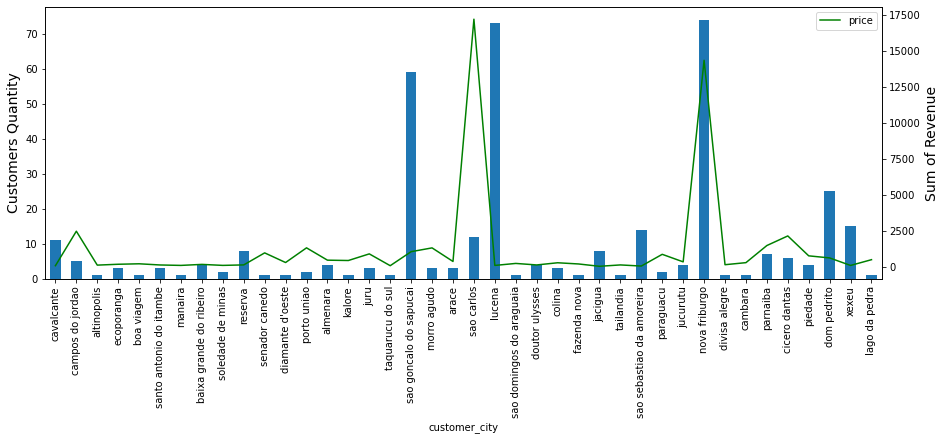

In [381]:
ax = aux_df['customer_id'].sample(40).plot(kind='bar', figsize=(15,5))
plt.ylabel("Customers Quantity", size=14)
aux_df['price'].sample(40).plot(kind='line', figsize=(15,5), ax = ax.twinx(), color='green')
plt.ylabel("Sum of Revenue", size=14)
plt.legend();

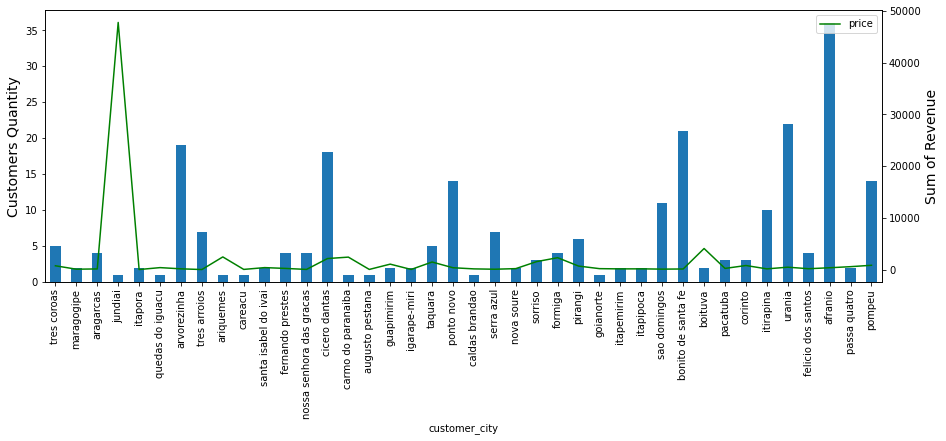

In [382]:
ax = aux_df['customer_id'].sample(40).plot(kind='bar', figsize=(15,5))
plt.ylabel("Customers Quantity", size=14)
aux_df['price'].sample(40).plot(kind='line', figsize=(15,5), ax = ax.twinx(), color='green')
plt.ylabel("Sum of Revenue", size=14)
plt.legend();

#### 4 - States with more customers have higher mean revenue.

Yes, but again, we can also see reverse facts.

In [394]:
aux_df = df.groupby("customer_state")[['customer_id','price']].agg({'customer_id':'nunique','price':'sum'}).sort_values("price", ascending=False)

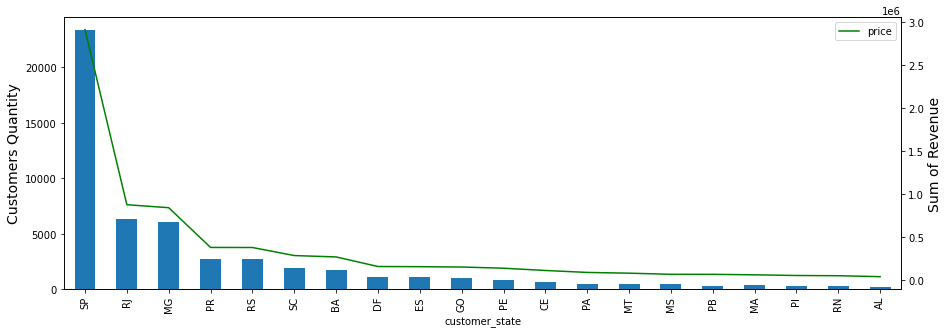

In [397]:
ax = aux_df['customer_id'].head(20).plot(kind='bar', figsize=(15,5))
plt.ylabel("Customers Quantity", size=14)
aux_df['price'].head(20).plot(kind='line', figsize=(15,5), ax = ax.twinx(), color='green')
plt.ylabel("Sum of Revenue", size=14)
plt.legend();

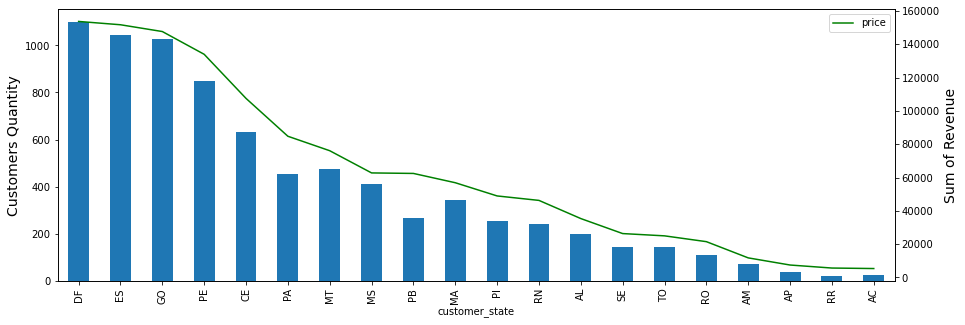

In [396]:
ax = aux_df['customer_id'].tail(20).plot(kind='bar', figsize=(15,5))
plt.ylabel("Customers Quantity", size=14)
aux_df['price'].tail(20).plot(kind='line', figsize=(15,5), ax = ax.twinx(), color='green')
plt.ylabel("Sum of Revenue", size=14)
plt.legend();

### 5.3 Multivariate Analysis

#### 5.3.1. Numerical Attributes

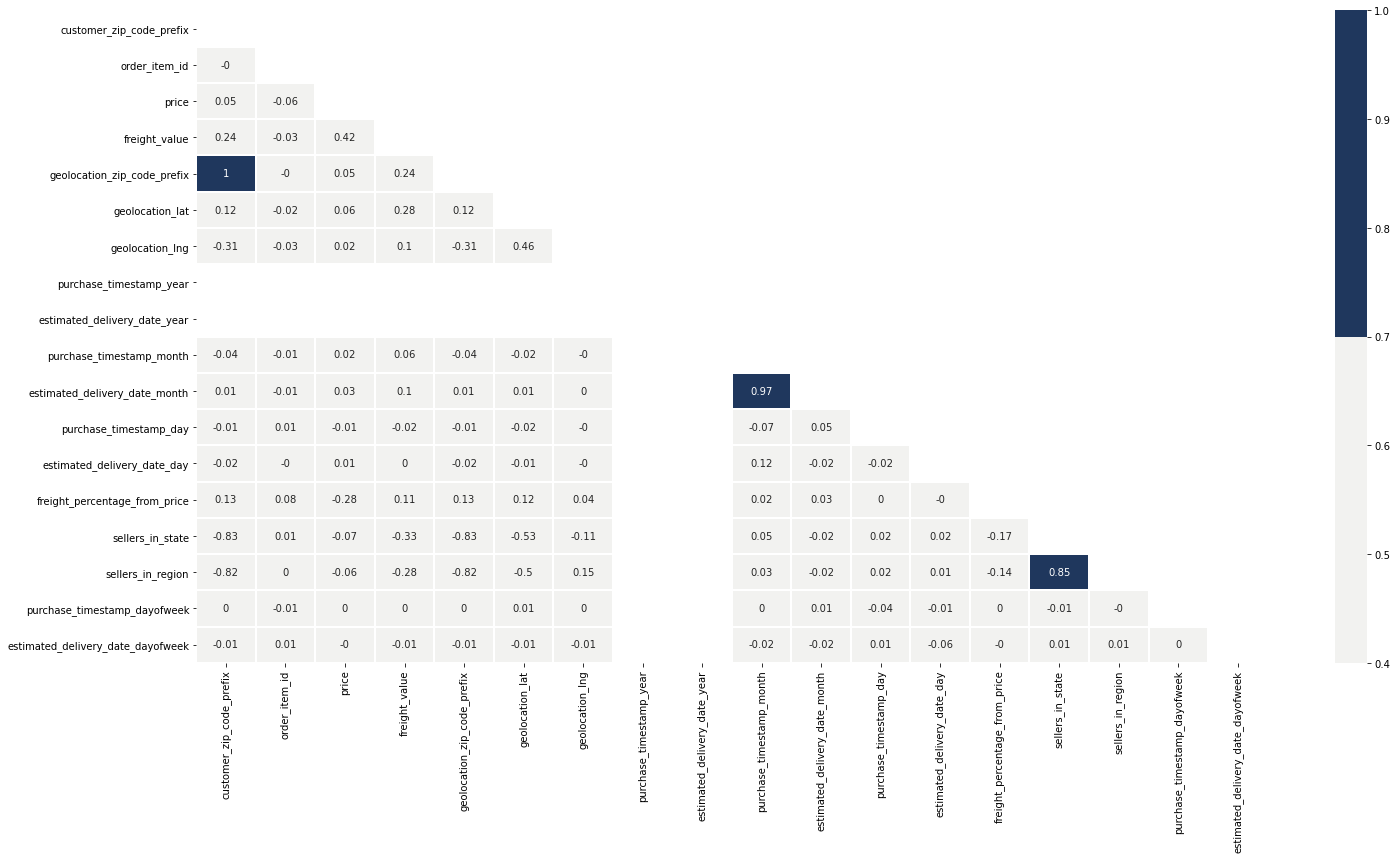

In [533]:
plt.figure(figsize=(24, 12))
correlations = numerical_attributes.corr().round(2)
mask = np.triu(np.ones_like(correlations, dtype=np.bool))
sns.heatmap(correlations, mask=mask, linewidths=1, annot=True, cmap=['#F2F2F0','#1F375D'], vmin=0.40) #vmax=-0.40
plt.show()

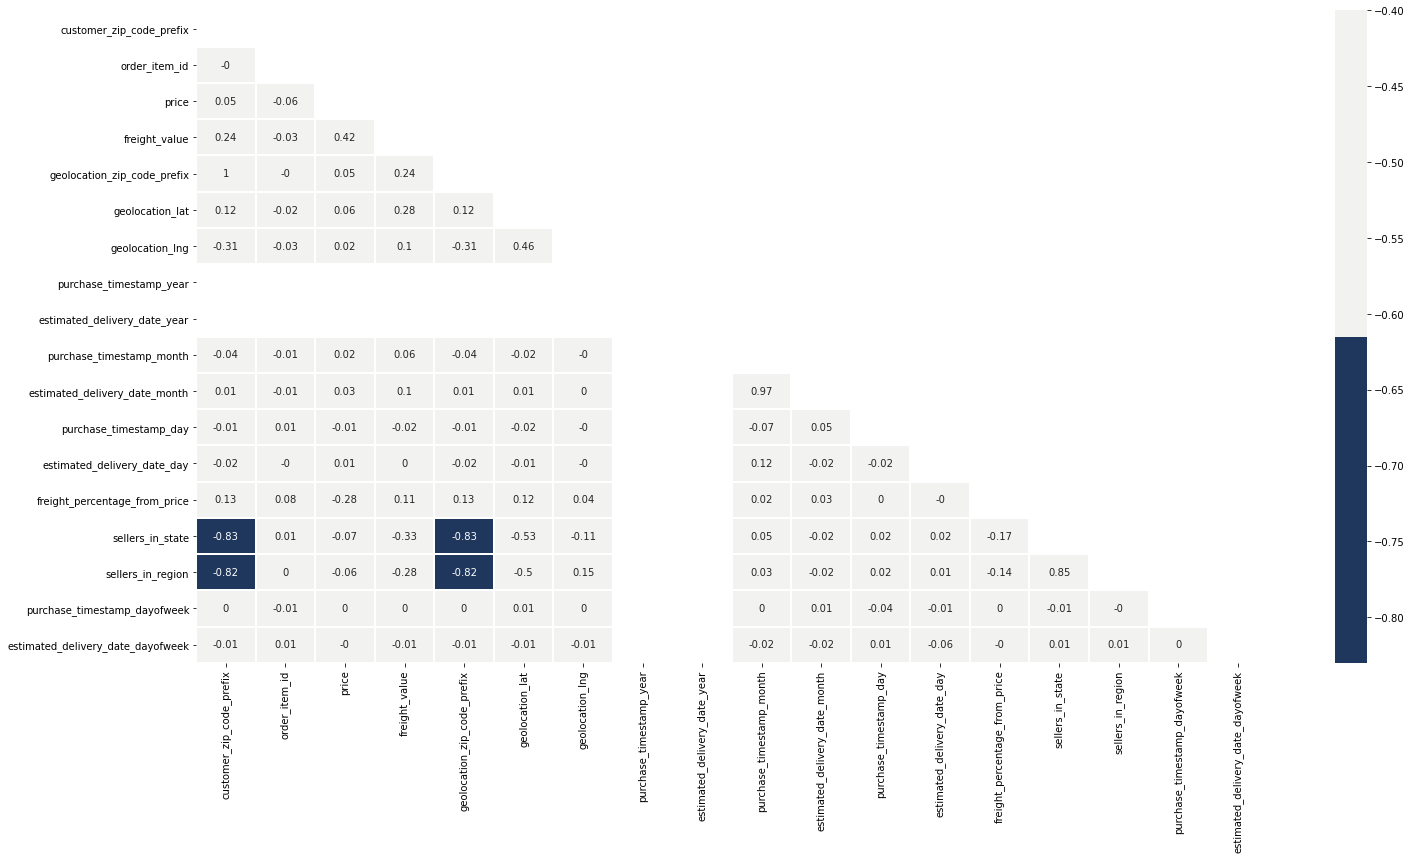

In [534]:
plt.figure(figsize=(24, 12))
correlations = numerical_attributes.corr().round(2)
mask = np.triu(np.ones_like(correlations, dtype=np.bool))
sns.heatmap(correlations, mask=mask, linewidths=1, annot=True, cmap=['#1F375D','#F2F2F0'], vmax=-0.40) #vmax=-0.40
plt.show()